In [1]:
import torch
from torch.autograd import grad
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
solver = scipy.integrate.solve_ivp

In [2]:
import pandas as pd

In [3]:
import torch.nn as nn
device = 'cpu'

In [4]:
class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2
            qqd = x.requires_grad_(True)
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0] ;
            DL_q, DL_qd = J[:,:n], J[:,n:]
            DDL_qd = []
            for i in range(n):
                J_qd_i = DL_qd[:,i][:,None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:])
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)
        return torch.cat([qqd[:,self.n:], qdd], 1)
    def _lagrangian(self, qqd):
        return self.L(qqd)

    def energy(self, qqd):
        n = qqd.shape[1]//2
        lag = self.L(qqd)
        lag_sum = lag.sum()
        lag_grad = grad(lag_sum, qqd, create_graph=False)[0] ;
        DL_q, DL_qd = lag_grad[:,:n], lag_grad[:,n:]
        dq = qqd[:,n:]
        inner_prod = (dq*DL_qd).sum(1, keepdim=True)
        energy = lag - inner_prod
        return energy    

In [5]:
input_size = 4
hidden_size = 200
output_size = 1

num_trials = 10

l_nn = LNN(nn.Sequential(
        nn.Linear(input_size,hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size,hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size,output_size))
     ).to(device)

In [6]:
M = 100 * 1
tend = 5.0 * 1
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

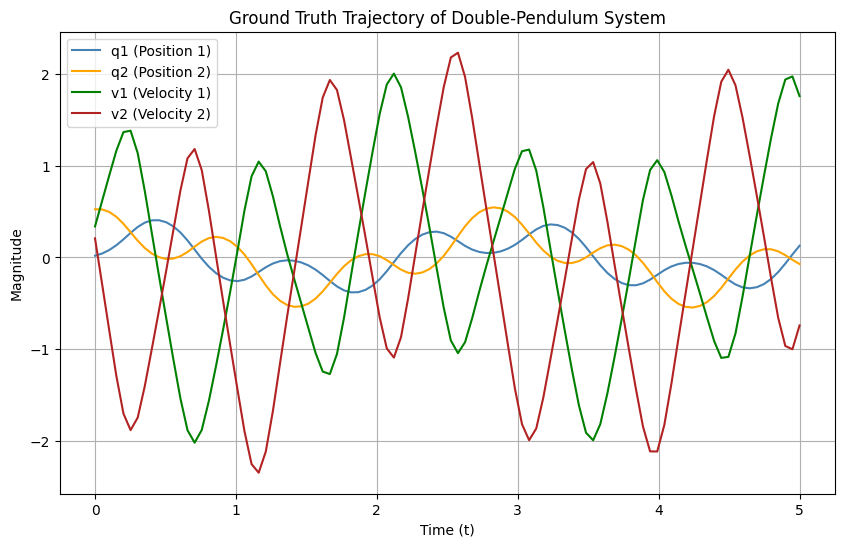

In [7]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

def func(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)

flag = False

for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  
  plt.figure(figsize=(10, 6))
  plt.plot(tval, q1, 'steelblue', label='q1 (Position 1)')
  plt.plot(tval, q2, 'orange', label='q2 (Position 2)')
  plt.plot(tval, v1, 'g', label='v1 (Velocity 1)')
  plt.plot(tval, v2, 'firebrick', label='v2 (Velocity 2)')
  plt.xlabel('Time (t)')
  plt.ylabel('Magnitude')
  plt.title('Ground Truth Trajectory of Double-Pendulum System')
  plt.legend()
  plt.grid(True)
  plt.show()

In [8]:
true_res = []

for i in range(q1.shape[0]):
    true_res.append(np.array([q1[i], q2[i], v1[i], v2[i]]))

true_res = np.array(true_res)
print('true_res:', true_res.shape)

true_res: (100, 4)


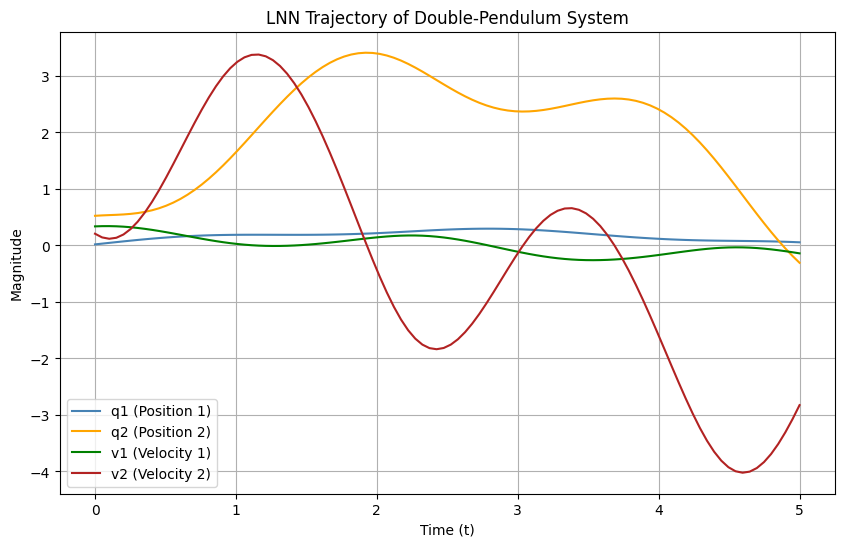

In [9]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)

trial = 9

l_nn.load_state_dict(torch.load("./model/lnn_dp_min_2t_lr_{}".format(trial), map_location=device))
l_nn.eval()
x0 = state[0]

import pandas as pd
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)

A = np.asmatrix(A)
B = np.asmatrix(B)
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
l_nn.eval()
l_nn.cpu()

def fvec_np(x,t):
    tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
    x = torch.matmul(tx, torch.inverse(B))
    output = l_nn.forward(x).squeeze(0)
    output = torch.matmul(A, output)
    output = output.squeeze(0)
    return output.detach().cpu().numpy() 

res = scipy.integrate.odeint(fvec_np,x0,t_eval)

plt.figure(figsize=(10, 6))
plt.plot(t_eval,res[:,0], 'steelblue', label='q1 (Position 1)')
plt.plot(t_eval,res[:,1], 'orange', label='q2 (Position 2)')
plt.plot(t_eval,res[:,2], 'g', label='v1 (Velocity 1)')
plt.plot(t_eval,res[:,3], 'firebrick', label='v2 (Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('LNN Trajectory of Double-Pendulum System')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
M1, M2, L1, L2, G = m1, m2, l1, l2, g

def Hamiltonian_ftn_double_pendulum(state):
    theta1 = state[0]
    theta2 = state[1]
    omega1 = state[2]
    omega2 = state[3]

    T1 = 0.5 * M1 * (L1 * omega1)**2
    T2 = 0.5 * M2 * (
        (L1 * omega1)**2 + 
        (L2 * omega2)**2 + 
        2 * L1 * L2 * omega1 * omega2 * np.cos(theta1 - theta2)
    )
    kinetic_energy = T1 + T2
    
    V1 = -M1 * G * L1 * np.cos(theta1)
    V2 = -M2 * G * (L1 * np.cos(theta1) + L2 * np.cos(theta2))
    potential_energy = V1 + V2

    return (kinetic_energy + potential_energy)

def true_energy(trajectory):
    energies = []
    for state_t in trajectory:
        energies.append(Hamiltonian_ftn_double_pendulum(state_t))

    return np.array(energies)

In [11]:
tres = torch.tensor(res, dtype=torch.float, requires_grad=True)
net_energy = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
Hmodel_lnn_x = net_energy.detach().cpu().numpy()

tres = torch.tensor(true_res, dtype=torch.float, requires_grad=True)
net_energy = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
Hmodel_true_x = net_energy.detach().cpu().numpy()

Htrue_lnn_x = true_energy(res).reshape((M))
Htrue_true_x = true_energy(true_res).reshape((M))

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_2x2_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_hnn_x, Hmodel_true_x, Hmodel_hnn_x):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 0].plot(t_eval, true_res[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 0].plot(t_eval, true_res[:, 2], 'orange', label='v1 (Velocity 1)')
    axes[0, 0].plot(t_eval, true_res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylim([-3,3])
    axes[0, 0].set_title('Ground Truth Trajectory')
    axes[0, 0].legend(loc='upper right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 1].plot(t_eval, res[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 1].plot(t_eval, res[:, 2], 'orange', label='v1 (Velocity 1)')
    axes[0, 1].plot(t_eval, res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    # axes[0, 1].set_ylim([-3,3])
    axes[0, 1].set_title('Trajectory Prediction By Lagrangian NN (LNN)')
    axes[0, 1].legend(loc='upper right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x, 'k-', label='H_true(true_u)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_lnn_x, 'b--', label='H_true(LNN_u)', linewidth=2)
    axes[1, 0].set_title("True Energy (u)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Hamiltonian H(u)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    # --- Bottom Right Plot (1, 1): Learned Hamiltonian Perspective ---
    axes[1, 1].plot(t_eval, Hmodel_true_x, 'k-', label='H_model(True_u)', linewidth=2)
    axes[1, 1].plot(t_eval, Hmodel_lnn_x, 'b--', label='H_model(LNN_u)', linewidth=2)
    axes[1, 1].set_title("Hamiltonian Learned by LNN (u)", pad=tpad)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Energy H_model(u)')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig("./eval_figures_per_model/lnn_asis_dbl_pend_eval_figure_by_danieljh.png", dpi=150) # PNG saved
    plt.show()


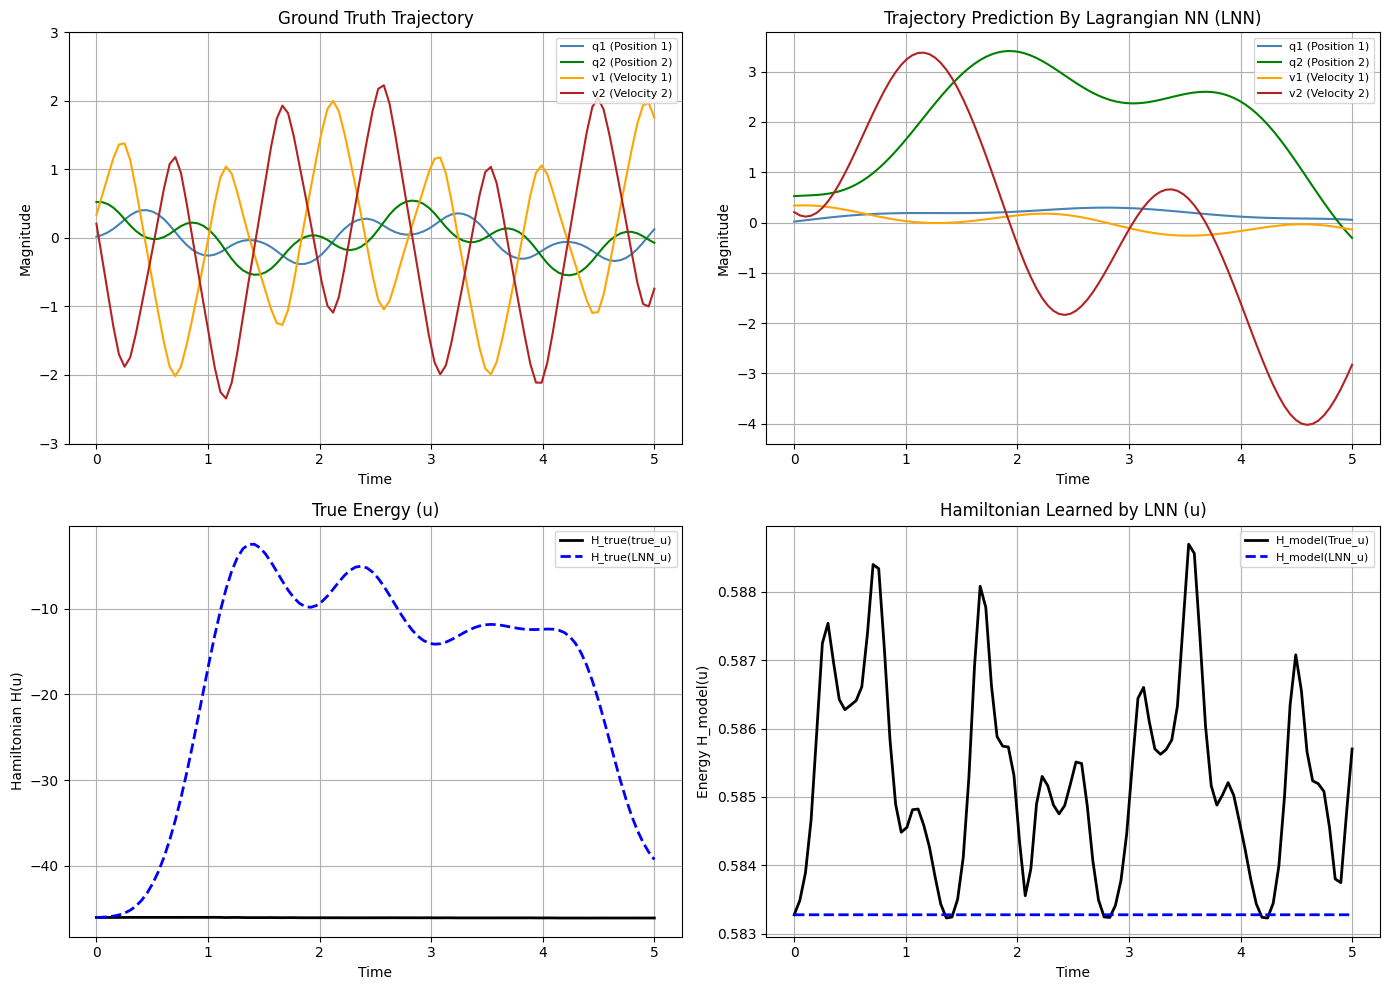

In [13]:
plot_2x2_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_lnn_x, Hmodel_true_x, Hmodel_lnn_x)

In [14]:
def save_data(data, model="TRUE", item='orbit', order="0123", t_end=tend, dir = './comparison'): 
    file_path = dir + f'/{model}_dbl_pend_{item}_order_{order}_tend_{t_end}.npy'
    np.save(file_path, data)

    print(f"Data have been saved to {file_path} file successfully.")

In [15]:
save_data(true_res)
save_data(res, model="LNN")
save_data(Htrue_true_x, model="LNN", item="Htrue_true_u")
save_data(Htrue_lnn_x, model="LNN", item='Htrue_lnn_u')
save_data(Hmodel_true_x, model="LNN", item='Hmodel_true_u')
save_data(Hmodel_lnn_x, model="LNN", item='Hmodel_lnn_u')

Data have been saved to ./comparison/TRUE_dbl_pend_orbit_order_0123_tend_5.0.npy file successfully.
Data have been saved to ./comparison/LNN_dbl_pend_orbit_order_0123_tend_5.0.npy file successfully.
Data have been saved to ./comparison/LNN_dbl_pend_Htrue_true_u_order_0123_tend_5.0.npy file successfully.
Data have been saved to ./comparison/LNN_dbl_pend_Htrue_lnn_u_order_0123_tend_5.0.npy file successfully.
Data have been saved to ./comparison/LNN_dbl_pend_Hmodel_true_u_order_0123_tend_5.0.npy file successfully.
Data have been saved to ./comparison/LNN_dbl_pend_Hmodel_lnn_u_order_0123_tend_5.0.npy file successfully.
